In [1]:
import numpy as np
import astropy.units as u
import yaml
import utils
import matplotlib.pyplot as plt

from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import FoVBackgroundModel, Models
from gammapy.modeling import Fit
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading general parameters
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
hessera = 'hess1'
muoneff_flag= cfg['muoneff_flag']
muoneff_flag=False

In [3]:
# defining the geometry for the datasets
energy_bins = np.logspace(-1, 2, cfg['N_ebins']+1)
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'bkg-peak'], offset_max=cfg['offset_cut'] * u.deg)

In [4]:
runlist = [18415, 80170]
muoneff_path = f'{cfg["muoneff_path"]}/{hessera}/hess1_hess2/v01c_kaori_mueff'

basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
table = ds.obs_table
observations = ds.get_observations(runlist)

No HDU found matching: OBS_ID = 18415, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 80170, HDU_TYPE = rad_max, HDU_CLASS = None


In [5]:
dataset_list = []
for obs in observations:
    # taking care of the correct bkg model (if it is muoneff or official model)
    # the official model is stored in the fits tables. For the muoneff model, we will just change the path of the bkg model
    if muoneff_flag:
        if obs.obs_info['MUONEFF'] > 0.085:
            model_CD = 'B'
        elif obs.obs_info['MUONEFF'] >= 0.075:
            model_CD = 'D'
        else:
            model_CD = 'C'

        if obs.obs_id >= 100000:
            run_number= f'{obs.obs_id}'
        else:
            run_number= f'0{obs.obs_id}'
        filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
        obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

    geom = WcsGeom.create(skydir=obs.pointing_radec, binsz=cfg['binsz'], width=cfg['width']* u.deg, frame="icrs", axes=[axis])        
    dataset = MapDataset.create(geom=geom)
    dataset = maker.run(dataset, obs)
    dataset = maker_safe_mask.run(dataset, obs)

    # create here mask_fit
    dataset.mask_fit = Map.from_geom(geom=geom, data=np.ones_like(dataset.counts.data).astype(bool))
    coord = utils.get_mask_fov(obs.pointing_radec.ra.deg, obs.pointing_radec.dec.deg, 5)
    if coord != 0: #this means that if there are regions to be masked
        for s in coord:
            dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"icrs;circle({s[0]}, {s[1]}, {s[2]})")
            
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = Models([bkg_model])
    dataset.background_model.spectral_model.tilt.frozen = False

    Fit().run(datasets=[dataset])

    dataset_list.append(dataset)

Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


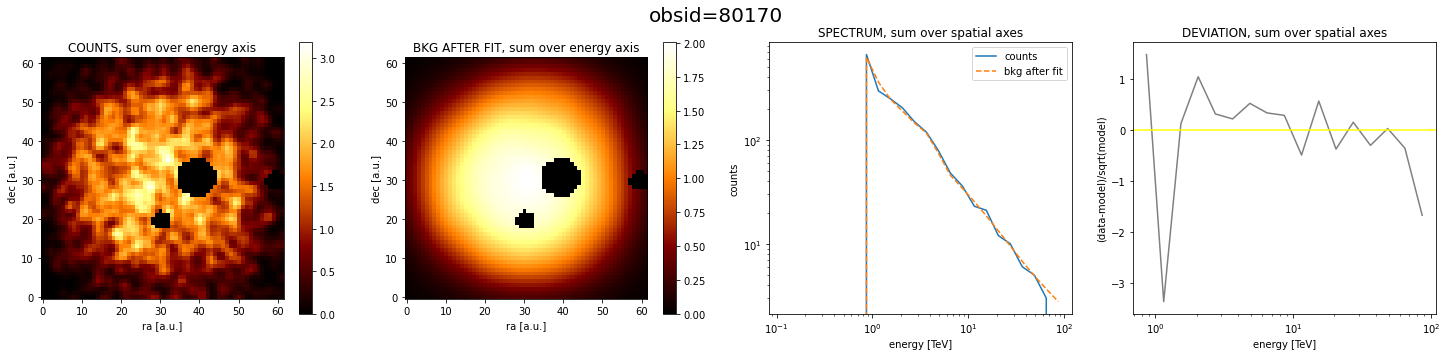

In [28]:
x_axis= dataset.counts.geom.axes['energy'].center.value

fig, ax = plt.subplots(1,4, figsize=(25, 5))

ax[0].set_title('COUNTS, sum over energy axis')
ax[1].set_title('BKG AFTER FIT, sum over energy axis')

for i in range(2):
    ax[i].set_xlabel('ra [a.u.]')
    ax[i].set_ylabel('dec [a.u.]')

(dataset.counts.smooth(1)*dataset.mask_fit).sum_over_axes().plot(add_cbar=True, ax=ax[0])
(dataset.npred().smooth(1)*dataset.mask_fit).sum_over_axes().plot(add_cbar=True, ax=ax[1])

c = np.nansum((dataset.counts * dataset.mask_fit *dataset.mask_safe).data, axis=(1, 2))
b = np.nansum((dataset.npred() * dataset.mask_fit *dataset.mask_safe).data, axis=(1, 2))
error = (c-b)/np.sqrt(b)

ax[2].plot(x_axis, c, label='counts')
ax[2].plot(x_axis, b, label='bkg after fit', ls='--')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_xlabel('energy [TeV]')
ax[2].set_ylabel('counts')
ax[2].set_title('SPECTRUM, sum over spatial axes')

ax[3].plot(x_axis, error, color='gray')
ax[3].set_xlabel('energy [TeV]')
ax[3].set_ylabel('(data-model)/sqrt(model)')
ax[3].axhline(0, color='yellow')
ax[3].set_xscale('log')
ax[3].set_title('DEVIATION, sum over spatial axes')

plt.suptitle(f'obsid={obs.obs_id}', size=20)


In [29]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
hesseras= ['hess1', 'hess2']
muoneff_flag= cfg['muoneff_flag']
bdt_edges = cfg['bdt_edges']

if muoneff_flag == False:
    print('ATTENTION, THIS SCRIPT IS MADE FOR BKG MODEL WITH MUONEFF BINNING')

model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

if N_ebins==24:
    e_center= [0.1154782 ,  0.15399265,  0.2053525 ,  0.27384197,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478201,  1.53992656,
            2.05352501,  2.73841962,  3.65174137,  4.86967527,  6.49381614,
            8.65964312, 11.54781997, 15.3992658 , 20.53525094, 27.38419634,
           36.51741269, 48.6967522 , 64.93816094, 86.59643066]

In [35]:
def get_results(hessera, muoneff_flag=True):
    
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    table = ds.obs_table
    
    # load results
    if hessera != 'hess1':
        file = np.loadtxt(f'results/dataspectrum_muoneff_{hessera}.txt')
    else:
        for idx in range(57):
            if idx==0:
                file = np.loadtxt(f'../1-error_estimation/results/dataspectrum_muoneff_{hessera}_part{idx}.txt')
                if muoneff_flag==False:
                    file = np.loadtxt(f'../1-error_estimation/results/dataspectrum_{hessera}.txt')
            else:
                if muoneff_flag==False:
                    file = np.concatenate((file, np.loadtxt(f'../1-error_estimation/results/dataspectrum_{hessera}_part{idx}.txt')))
                else:
                    file = np.concatenate((file, np.loadtxt(f'../1-error_estimation/results/dataspectrum_muoneff_{hessera}_part{idx}.txt')))
    obsid_list = file[:, 0].astype(int)
    obsid_list_original = np.loadtxt(f'../1-error_estimation/initial_runlist_{hessera}.txt').astype(int)
    print(f'there are {len(obsid_list_original)-len(obsid_list)}/{len(obsid_list_original)} with problems')

    # getting the error per run in units of statistical standard deviation and in units of bkg percentage
    counts=file[:, 1:N_ebins+1]
    background = file[:, N_ebins+1:]
    error_std = (counts - background)/np.sqrt(background)
    error_percentage = 100*(counts - background)/background

    #getting information of zenith and model of each run (these are the bins for error estimation)
    info = []
    for obs in obsid_list:
        idx = np.where(table['OBS_ID']==obs)[0][0]
        zen_pnt = table['ZEN_PNT'][idx]
        zen_bin = np.sum(zen_pnt > zen_bins) - 1

        muoneff = table['MUONEFF'][idx]
        if muoneff > 0.085:
            model = 0 #'B'
        elif muoneff >= 0.075:
                model = 1 # 'D'
        else:
            model = 2 #'C'

        info.append([obs, zen_pnt, zen_bin, model])
    info= np.asarray(info)

    return info, error_std, error_percentage
    
def calculate_error(info, error_std, error_percentage):
    
    def plot(res, model, zen, ax_idx):
        ax[ax_idx][zen].plot(e_center, res.T, color='lightgray');
        ax[ax_idx][zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'{model_str[model]}\nN_runs={np.sum(mask)}');
        ax[ax_idx][zen].set_xscale('log')
        ax[ax_idx][zen].legend(loc='lower right')
        if ax_idx < 3:
            ax[ax_idx][zen].set_ylim(-10,10)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [std]')
        else:
            ax[ax_idx][zen].set_ylim(-50,50)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [bkg %]')
            

    # 7 corresponds to zen bins, 3 to 
    N_est = np.ndarray((7, 3, 1), dtype=int)
    er_est = np.ndarray((7, 3, 2, 24)) #error for 7 zenbins, 3 bkg models, 2 units of error std and percentage, 24 energy bins 
    std_est = np.ndarray((7, 3, 2, 24)) # here is the std of the error
    
    fig, ax = plt.subplots(6, 7, figsize=(3*12,24))
    for zen in range(7):
        for model in range(3):
            mask_zen = info.T[2] == zen
            mask_model = info.T[3] == model
            mask = mask_zen & mask_model
            N_est[zen][model][0] = np.sum(mask)
            
            if np.sum(mask) == 0:
                print(f'no runs for zen={zen}, model={model_str[model]}')
            else:            
                er_est[zen][model][0] = np.nanmean(error_std[mask].T, axis=1)
                er_est[zen][model][1] = np.nanmean(error_percentage[mask].T, axis=1)
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)
    
    #this is to avoid the low statistics problem for the first zenith bin, high energies
    for i, er in enumerate(er_est[0][0][0]):
        if er > 5:
            er_est[0][0][0][i] = 0.2
            
    return N_est, er_est, std_est

there are 0/11342 with problems


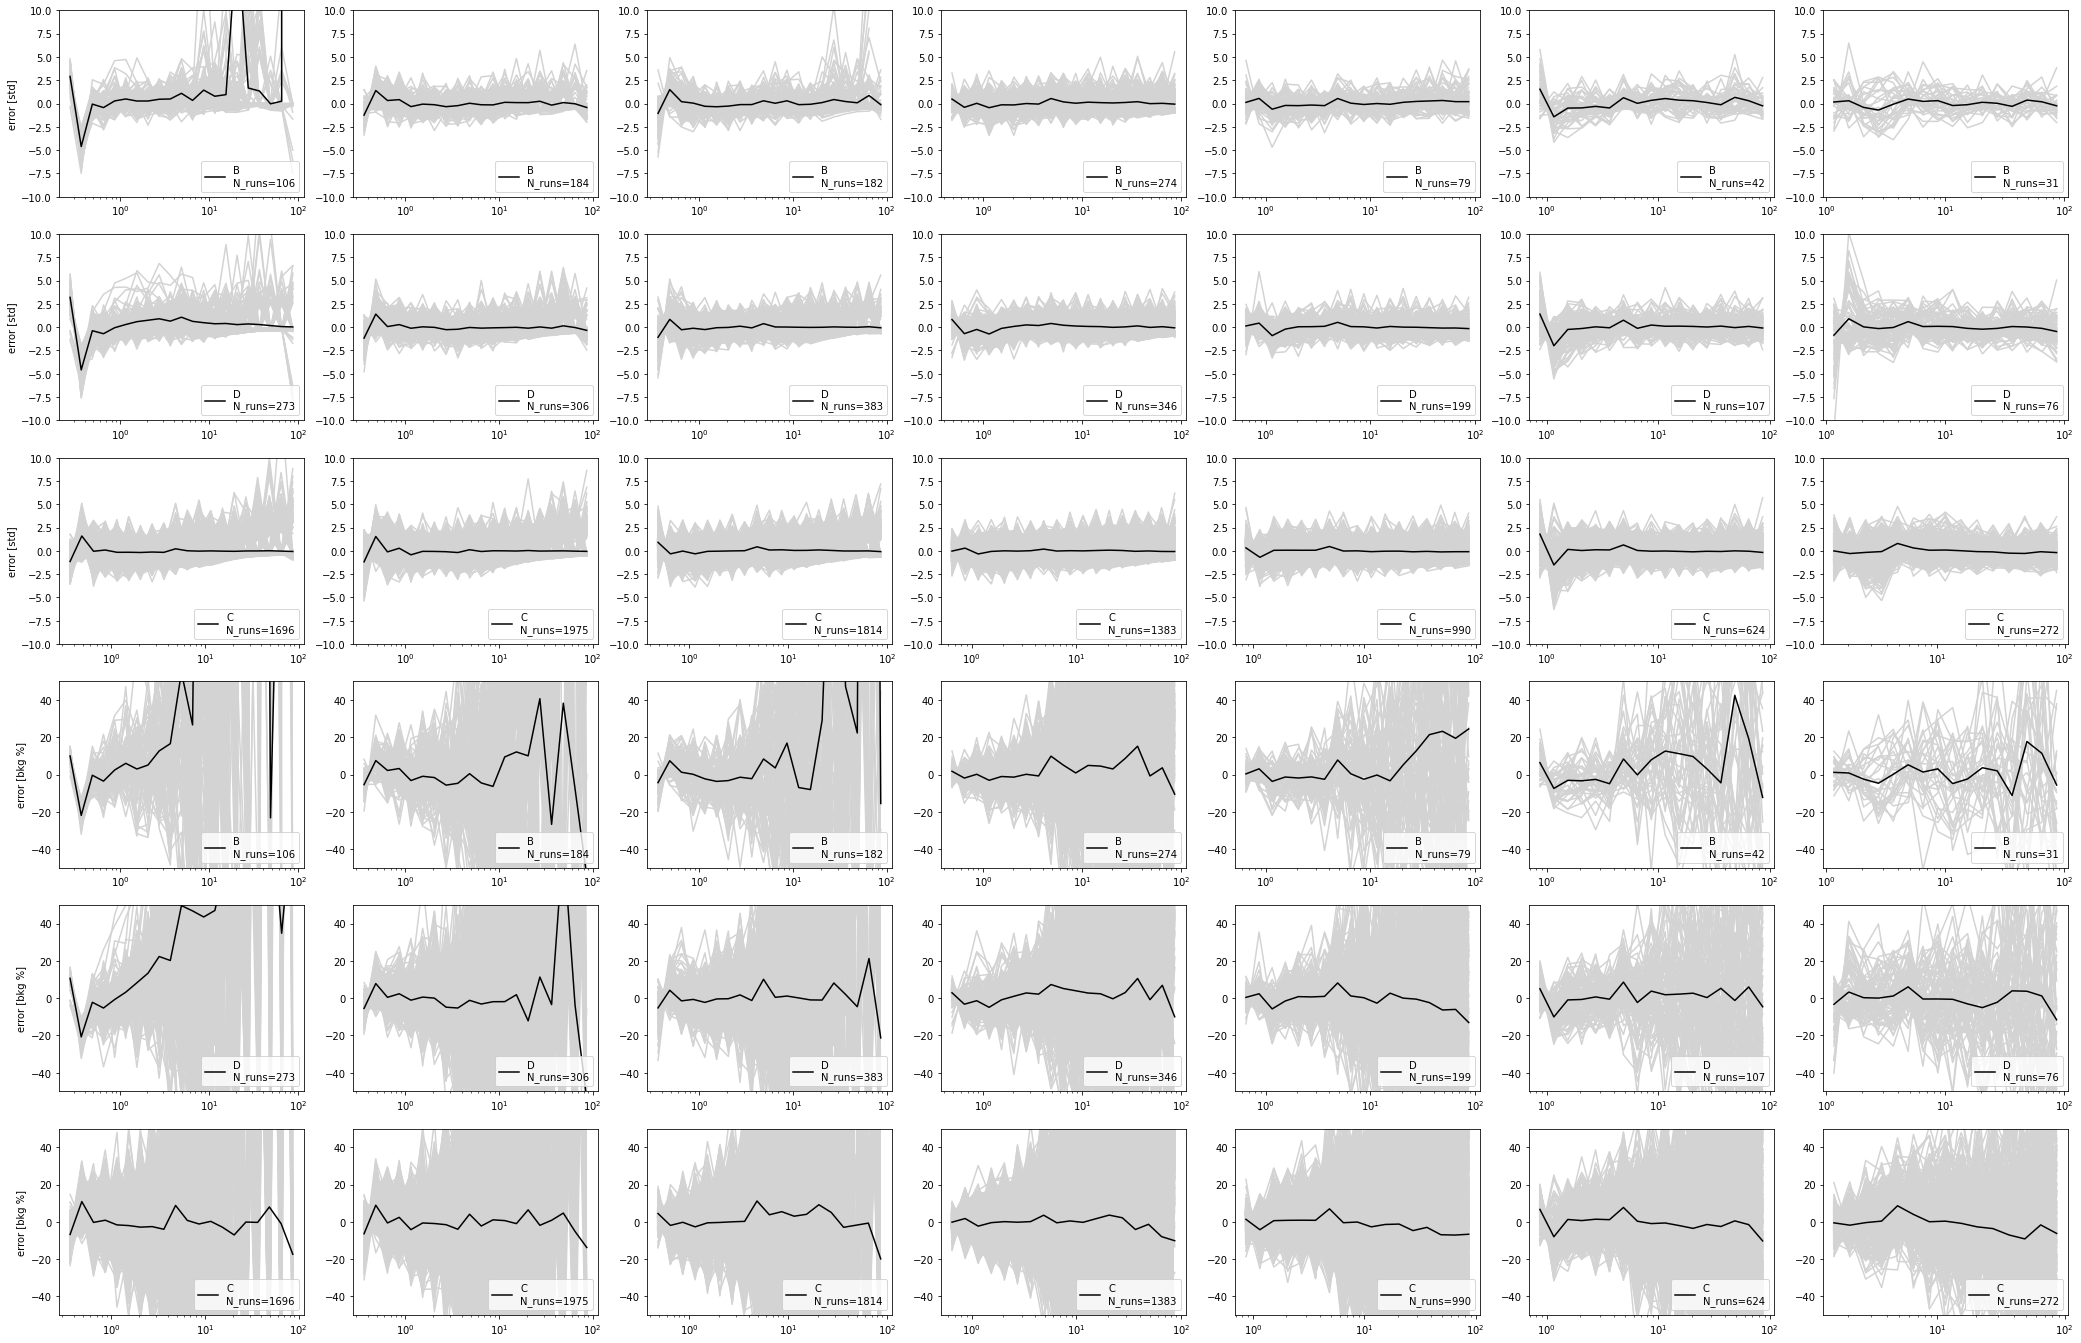

In [36]:
hessera = 'hess1'
info, error_std, error_percentage = get_results(hessera)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

Text(0, 0.5, 'error [std]')

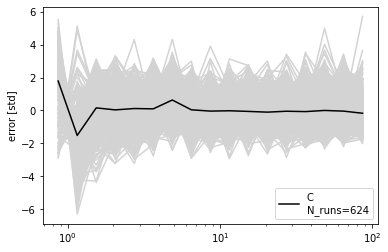

In [39]:
mask_zen = info.T[2] == 5
mask_model = info.T[3] == 2
mask = mask_zen & mask_model
N_est[5][2][0] = np.sum(mask)

res=error_std[mask]
plt.plot(e_center, res.T, color='lightgray');
plt.plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'{model_str[2]}\nN_runs={np.sum(mask)}');
plt.xscale('log')
plt.legend(loc='lower right')
plt.ylabel(f'error [std]')

Text(0.5, 0.98, 'error estimation, units of statistical std')

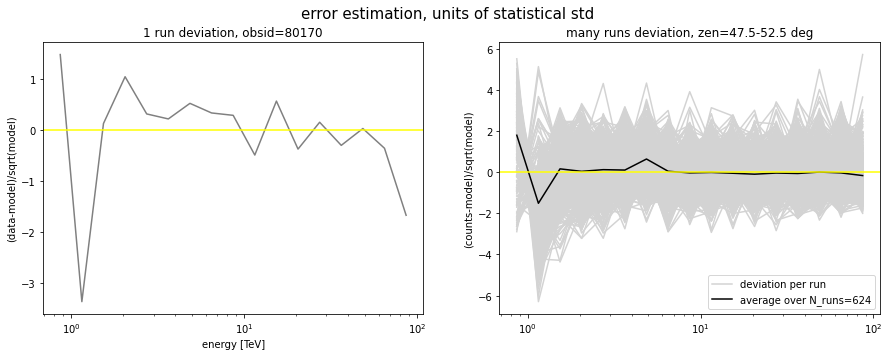

In [63]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(x_axis, error, color='gray')
ax[0].set_xlabel('energy [TeV]')
ax[0].set_ylabel('(data-model)/sqrt(model)')
ax[0].axhline(0, color='yellow')
ax[0].set_xscale('log')
ax[0].set_title(f'1 run deviation, obsid={obs.obs_id}')

res=error_std[mask]
ax[1].plot(e_center, res.T, color='lightgray');
ax[1].plot(e_center, np.nanmean(res.T, axis=1), color='lightgray', label=f'deviation per run');
ax[1].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'average over N_runs={np.sum(mask)}');
ax[1].set_xscale('log')
ax[1].legend(loc='lower right')
ax[1].set_ylabel(f'(counts-model)/sqrt(model)')
ax[1].set_title(f'many runs deviation, zen=47.5-52.5 deg')
ax[1].axhline(0, color='yellow')

plt.suptitle('error estimation, units of statistical std', size=15)

Text(0.5, 0.98, 'error estimation, units % of bkg')

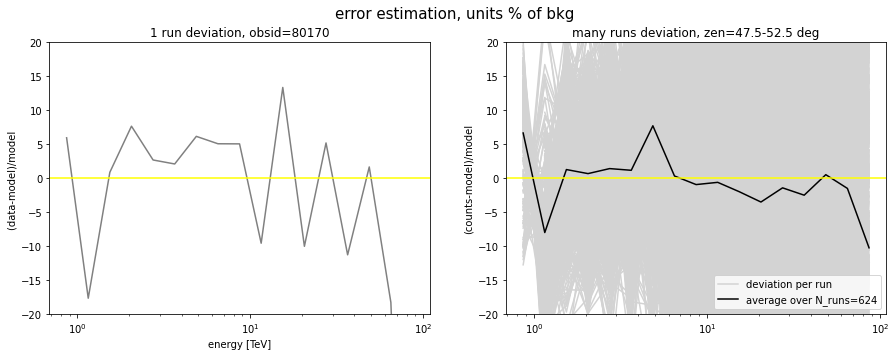

In [65]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(x_axis, 100*error/np.sqrt(b), color='gray')
ax[0].set_xlabel('energy [TeV]')
ax[0].set_ylabel('(data-model)/model ')
ax[0].axhline(0, color='yellow')
ax[0].set_xscale('log')
ax[0].set_title(f'1 run deviation, obsid={obs.obs_id}')
ax[0].set_ylim(-20,20)


res=error_percentage[mask]
ax[1].plot(e_center, res.T, color='lightgray');
ax[1].plot(e_center, np.nanmean(res.T, axis=1), color='lightgray', label=f'deviation per run');
ax[1].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'average over N_runs={np.sum(mask)}');
ax[1].set_xscale('log')
ax[1].legend(loc='lower right')
ax[1].set_ylabel(f'(counts-model)/model')
ax[1].set_title(f'many runs deviation, zen=47.5-52.5 deg')
ax[1].set_ylim(-20,20)
ax[1].axhline(0, color='yellow')


plt.suptitle('error estimation, units % of bkg', size=15)

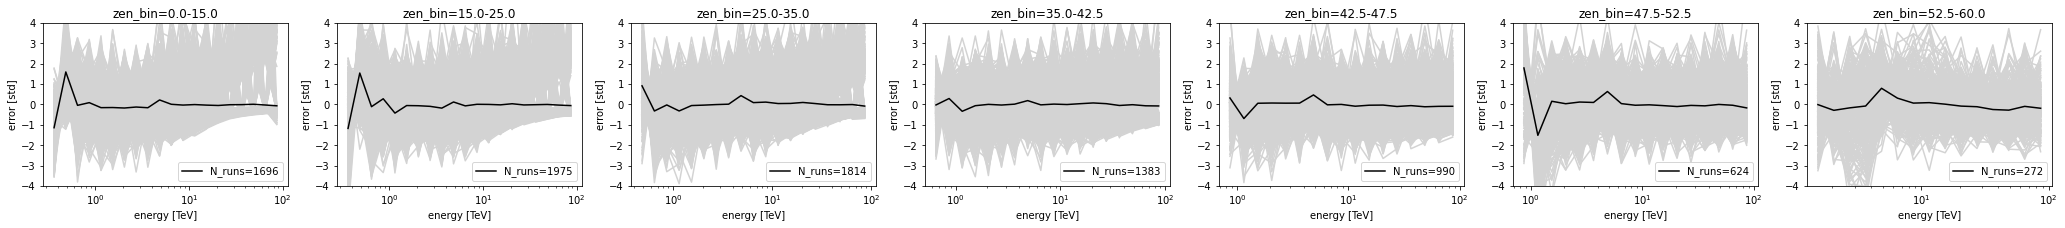

In [71]:
fig, ax = plt.subplots(1, 7, figsize=(3*12,3))
for zen in range(7):
    mask_zen = info.T[2] == zen
    mask_model = info.T[3] == 2
    mask = mask_zen & mask_model
    N_est[5][2][0] = np.sum(mask)

    res=error_std[mask]
    ax[zen].plot(e_center, res.T, color='lightgray');
    ax[zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'N_runs={np.sum(mask)}');
    ax[zen].set_xscale('log')
    ax[zen].legend(loc='lower right')
    ax[zen].set_ylabel(f'error [std]')
    ax[zen].set_xlabel(f'energy [TeV]')
    ax[zen].set_title(f'zen_bin={zen_bins[zen]}-{zen_bins[zen+1]}')
    ax[zen].set_ylim(-4,4)

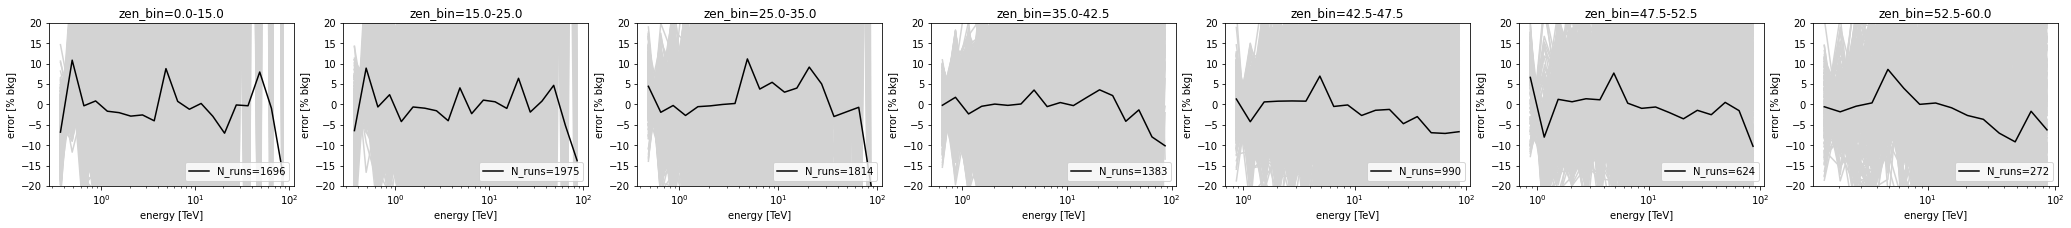

In [72]:
fig, ax = plt.subplots(1, 7, figsize=(3*12,3))
for zen in range(7):
    mask_zen = info.T[2] == zen
    mask_model = info.T[3] == 2
    mask = mask_zen & mask_model
    N_est[5][2][0] = np.sum(mask)

    res=error_percentage[mask]
    ax[zen].plot(e_center, res.T, color='lightgray');
    ax[zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'N_runs={np.sum(mask)}');
    ax[zen].set_xscale('log')
    ax[zen].legend(loc='lower right')
    ax[zen].set_ylabel(f'error [% bkg]')
    ax[zen].set_xlabel(f'energy [TeV]')
    ax[zen].set_title(f'zen_bin={zen_bins[zen]}-{zen_bins[zen+1]}')
    ax[zen].set_ylim(-20,20)

<Figure size 1440x1440 with 0 Axes>

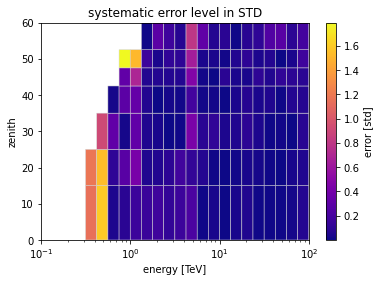

<Figure size 1440x1440 with 0 Axes>

In [114]:
xedges=energy_bins
yedges=zen_bins

X,Y = np.meshgrid(xedges, yedges)
plt.pcolor(X, Y, abs(er_est[:, 2, 0, :]), edgecolors='lightgray', linewidths=0.5, cmap='plasma')
cbar=plt.colorbar()
cbar.set_label('error [std]')
plt.xscale('log')
plt.ylabel('zenith')
plt.xlabel('energy [TeV]')
plt.title('systematic error level in STD')
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

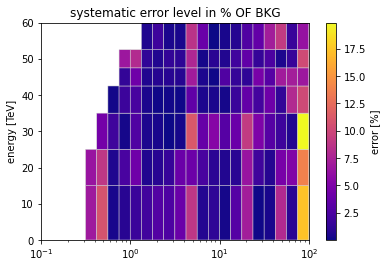

<Figure size 1440x1440 with 0 Axes>

In [115]:
xedges=energy_bins
yedges=zen_bins

X,Y = np.meshgrid(xedges, yedges)
plt.pcolor(X, Y, abs(er_est[:, 2, 1, :]), edgecolors='lightgray', linewidths=0.5, cmap='plasma')
cbar=plt.colorbar()
cbar.set_label('error [%]')
plt.xscale('log')
plt.ylabel('zenith')
plt.ylabel('energy [TeV]')
plt.title('systematic error level in % OF BKG')
plt.figure(figsize=(20,20))